# Lab 5 : Mixture Models+Model orden selection 

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD5"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L5_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# sns.set_context('poster')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

$\mu = \frac{1}{n} \sum_{i=1}^n x_i$

In [2]:
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans


class my_GMM():
    
    def __init__(self, k):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k = k
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
    def _compute_condition_prob_matrix(self, X):
            '''Compute the conditional probability matrix 
            shape: (n, K)
            '''
            n = X.shape[0]
            prob_matrix = np.zeros((n, self.k))
            
            for j in range(self.k):
                prob_matrix[:, j] = self.alpha_[j] * multivariate_normal.pdf(
                    X, mean=self.mu_[j], cov=self.Sigma_[j]
                )
                
            # Normalize probabilities
            row_sums = prob_matrix.sum(axis=1)
            prob_matrix /= row_sums[:, np.newaxis]
            
            return prob_matrix
    
    def _compute_log_likelihood(self, X):
        n = X.shape[0]
        prob_matrix = np.zeros((n, self.k))
        
        for j in range(self.k):
            prob_matrix[:, j] = self.alpha_[j] * multivariate_normal.pdf(
                X, mean=self.mu_[j], cov=self.Sigma_[j]
            )
            
        return np.sum(np.log(prob_matrix.sum(axis=1)))    

    def fit(self, X, max_iter = 1000, tolerance = 1e-6):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        # TODO:
        # initialize the parameters
        # apply sklearn kmeans or randomly initialize them
        n, p = X.shape
        
        # Initialize parameters using KMeans
        kmeans = KMeans(n_clusters=self.k, n_init=10)
        initial_labels = kmeans.fit_predict(X)
        
        # Initialize parameters
        self.alpha_ = np.zeros(self.k)
        self.mu_ = np.zeros((self.k, p))
        self.Sigma_ = np.zeros((self.k, p, p))
        
        # Set initial values based on KMeans results
        for j in range(self.k):
            mask = (initial_labels == j)
            cluster_points = X[mask]
            
            self.alpha_[j] = np.mean(mask)
            self.mu_[j] = np.mean(cluster_points, axis=0)
            self.Sigma_[j] = np.cov(cluster_points.T)
            
            # Add small value to diagonal to ensure positive definiteness
            self.Sigma_[j] += np.eye(p) * 1e-6
        
        old_log_likelihood = -np.inf
        
        for iteration in range(max_iter):
            # E-step: Compute conditional probabilities
            self.cond_prob_ = self._compute_condition_prob_matrix(X)
            
            # M-step: Update parameters
            # Update alpha (mixing coefficients)
            self.alpha_ = np.mean(self.cond_prob_, axis=0)
            
            # Update mu (means)
            for j in range(self.k):
                weighted_sum = np.sum(self.cond_prob_[:, j:j+1] * X, axis=0)
                self.mu_[j] = weighted_sum / (n * self.alpha_[j])
            
            # Update Sigma (covariance matrices)
            for j in range(self.k):
                diff = X - self.mu_[j]  # (n, p)
                weighted_diff = np.sqrt(self.cond_prob_[:, j:j+1]) * diff  # (n, p)
                self.Sigma_[j] = (weighted_diff.T @ weighted_diff) / (n * self.alpha_[j])
                self.Sigma_[j] += np.eye(p) * 1e-6  # Ensure positive definiteness
            
            # Check convergence
            log_likelihood = self._compute_log_likelihood(X)
            if np.abs(log_likelihood - old_log_likelihood) < tolerance:
                break
            old_log_likelihood = log_likelihood
        
        # Update labels
        self.labels_ = np.argmax(self.cond_prob_, axis=1)
        return self
    
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        proba = self.compute_proba(X)
        return np.argmax(proba, axis=1).astype(int)
        
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        return self._compute_condition_prob_matrix(X)

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

C:\Users\emili\AppData\Local\Temp\ipykernel_1432\2605317313.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X1 = np.random.multivariate_normal(mean1, cov1, n1)
C:\Users\emili\AppData\Local\Temp\ipykernel_1432\2605317313.py:19: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X3 = np.random.multivariate_normal(mean3, cov3, n3)


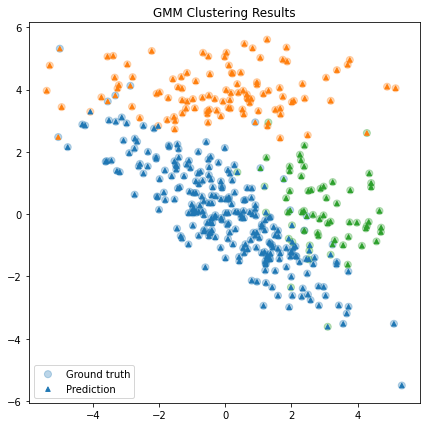

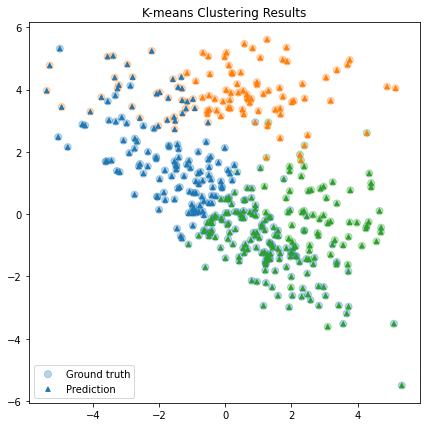

In [13]:
def generate_test_data(n_samples=300):
    np.random.seed(42)
    
    n1 = int(n_samples * 0.6)
    mean1 = np.array([0, 0])
    cov1 = np.array([[3, -2], [-3, 3]])
    X1 = np.random.multivariate_normal(mean1, cov1, n1)
    y1 = np.zeros(n1)
    
    n2 = int(n_samples * 0.25)
    mean2 = np.array([0, 4])
    cov2 = np.array([[4, 0], [0, 0.5]])
    X2 = np.random.multivariate_normal(mean2, cov2, n2)
    y2 = np.ones(n2)
    
    n3 = n_samples - n1 - n2
    mean3 = np.array([3, 0])
    cov3 = np.array([[0, 2], [1, 0]])
    X3 = np.random.multivariate_normal(mean3, cov3, n3)
    y3 = np.ones(n3) * 2
    
    X = np.vstack((X1, X2, X3))
    y = np.hstack((y1, y2, y3))
    
    return X, y.astype(int)


def plot_results(X, y_true, y_pred, title, colors_matching):
    plt.figure(figsize=(7, 7))
    plt.scatter(X[:, 0], X[:, 1], c=[f"C{i}" for i in y_true], s=50, alpha=0.3, label = "Ground truth")
    plt.scatter(X[:, 0], X[:, 1], c=[colors_matching[i] for i in y_pred], marker="^", s=20, label="Prediction")
    plt.title(title)
    plt.legend()
    plt.show()

# Generate data and test
X, y_true = generate_test_data(400)

# Fit GMM
gmm = my_GMM(k=3)
gmm.fit(X)
y_pred_gmm = gmm.predict(X)

# Compare with KMeans
kmeans = KMeans(n_clusters=3, n_init=10)
y_pred_kmeans = kmeans.fit_predict(X)
# Plot results
plot_results(X, y_true, y_pred_gmm, "GMM Clustering Results", ["C1", "C2", "C0"])
plot_results(X, y_true, y_pred_kmeans, "K-means Clustering Results", ["C1", "C0", "C2"])